# Classification 2

## 1. Classification of Gender

In [1]:
# Import dependencies
import ftfy
import nltk
import json

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Binarizer, StandardScaler

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import re

from collections import Counter
from os import listdir, makedirs
from os.path import isfile, join, splitext, split

import warnings
warnings.filterwarnings('ignore')

### Helper Functions and Document Class

In [2]:
def print_cv_scores_summary(name, scores):
    print("{}: mean = {:.2f}%, sd = {:.2f}%, min = {:.2f}, max = {:.2f}".format(name, scores.mean()*100, scores.std()*100, scores.min()*100, scores.max()*100))
    
def confusion_matrix_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    dims = (5, 5)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(cmdf, annot=True, cmap="coolwarm", center=0)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')

In [3]:
hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")
url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")

def preprocess(text):
    p_text = hashtag_re.sub("[hashtag]",text)
    p_text = mention_re.sub("[mention]",p_text)
    p_text = url_re.sub("[url]",p_text)
    p_text = ftfy.fix_text(p_text)
    return p_text

tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") #([]|words|other non-space)
def tokenise(text):
    return tokenise_re.findall(text)

class Document:
    def __init__(self, meta={}):
        self.meta = meta
        self.tokens_fql = Counter() #empty Counter, ready to be added to with Counter.update.
        self.ht_fql = Counter()
        self.num_tokens = 0
        
    def extract_features_from_text(self, text):
        hts = hashtag_re.findall(text)
        self.ht_fql.update([ht.lower() for ht in hts])
        p_text = preprocess(text)
        tokens = tokenise(p_text)
        lower_tokens = [t.lower() for t in tokens]
        self.num_tokens += len(lower_tokens)
        self.tokens_fql.update(lower_tokens) #updating Counter counts items in list, adding to existing Counter items.
        
    def extract_features_from_texts(self, texts): #texts should be iterable text lines, e.g. read in from file.
        for text in texts:
            extract_features_from_text(text)
            
    def average_token_length(self):
        sum_lengths = 0
        for key, value in self.tokens_fql.items():
            sum_lengths += len(key) * value
        return sum_lengths / self.num_tokens

### Load Data

In [4]:
def import_celebs_json(folder):
    jsonfiles = [join(folder, f) for f in listdir(folder) if isfile(join(folder, f)) and f.endswith(".json")]
    for jf in jsonfiles:
        with open(jf) as f:
            data = json.load(f)
            handle = data['handle']
            gender = data['gender']
            age_range = data['age_range']
            english = data['english']
        print("Processing " + handle)
        doc = Document(meta={'handle': handle, 'gender': gender, 'age_range': age_range, 'english': english}) #include metadata
        for tweet in data['tweets']:
            doc.extract_features_from_text(tweet['text'])
        yield doc

In [8]:
corpus = []
corpus.extend(import_celebs_json("celebs-json"))

Processing RealDMitchell
Processing AvanJogia
Processing Jessicaveronica
Processing ThaboSefolosha
Processing ChandraCrawford
Processing jaysean
Processing Beverleyknight
Processing alex_harvey
Processing Fearnecotton
Processing rosemaryCNN
Processing RickSanchezTV
Processing cmoffat
Processing Padmasree
Processing PritishNandy
Processing Mikkelson12
Processing PadmaLakshmi
Processing ShashiTharoor
Processing hyphen18
Processing TheVijayMallya
Processing LisaHannigan
Processing TomCavalcante1
Processing chuckcomeau
Processing GReefah
Processing jordysmith88
Processing rubarrichello
Processing jessicalowndes
Processing HasheemTheDream
Processing michelkreder
Processing Todd_McFarlane
Processing neilhimself
Processing imogenheap
Processing louiespence
Processing NathanFillion
Processing Bevilaqua41
Processing NelsonPiquet
Processing iamsrk
Processing ItsStephRice
Processing bobburnquist
Processing CelinaJaitly
Processing vitorbelfort
Processing julianperretta
Processing christianmeier
Pr

### Train/Test Split

In [9]:
y = [d.meta['gender'] for d in corpus]
X = corpus

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

223 56
223 56


### Document Processor

In [11]:
# Takes in one dataset and transforms it into a set of features using parameter-defined callable method
class DocumentProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, process_method):
        self.process_method = process_method
    
    def fit(self, X, y=None): #no fitting necessary, although could use this to build a vocabulary for all documents, and then limit to set (e.g. top 1000).
        return self

    def transform(self, documents):
        for document in documents:
            yield self.process_method(document)

In [13]:
def get_tokens_fql(document):
    return document.tokens_fql

def get_ht_fql(document):
    return document.ht_fql

def get_text_stats(document):
    ttr = len(document.tokens_fql) / document.num_tokens
    return {'avg_token_length': document.average_token_length(), 'ttr': ttr }

def read_list(file):
    with open(file) as f:
        items = []
        lines = f.readlines()
        for line in lines:
            items.append(line.strip())
    return items

fws = read_list("functionwords.txt")

def get_fws_fql(document):
    fws_fql = Counter({t: document.tokens_fql[t] for t in fws}) #dict comprehension, t: fql[t] is token: freq.
    return +fws_fql

### Build Pipeline

In [14]:
model = Pipeline([
    ('processor', DocumentProcessor(process_method = get_ht_fql)),
    ('vectorizer', DictVectorizer()),
    ('standardize', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
])

In [15]:
cv_scores = cross_validate(model, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), return_train_score=False, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
print_cv_scores_summary("Accuracy", cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", cv_scores['test_f1_weighted'])

Accuracy: mean = 74.20%, sd = 2.05%, min = 71.43, max = 76.79
Precision: mean = 73.82%, sd = 7.09%, min = 65.27, max = 82.37
Recall: mean = 74.20%, sd = 2.05%, min = 71.43, max = 76.79
F1: mean = 68.49%, sd = 1.35%, min = 65.84, max = 69.50


### Feature Union

In [16]:
# Concatenate different feature sets together
model = Pipeline([
    ('text_union', FeatureUnion(
        transformer_list = [
            ('ht_features', Pipeline([
                ('ht_processor', DocumentProcessor(process_method = get_ht_fql)),
                ('ht_vectorizer', DictVectorizer()),
            ])),
            ('fws_features', Pipeline([
                ('fws_processor', DocumentProcessor(process_method = get_fws_fql)),
                ('fws_vectorizer', DictVectorizer()),
            ])),
            ('stats_features', Pipeline([
                ('stats_processor', DocumentProcessor(process_method = get_text_stats)),
                ('stats_vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    ('standardize', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(solver='liblinear', random_state=0)),
])

In [17]:
cv_scores = cross_validate(model, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), return_train_score=False, scoring=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'])
print_cv_scores_summary("Accuracy", cv_scores['test_accuracy'])
print_cv_scores_summary("Precision", cv_scores['test_precision_weighted'])
print_cv_scores_summary("Recall", cv_scores['test_recall_weighted'])
print_cv_scores_summary("F1", cv_scores['test_f1_weighted'])

Accuracy: mean = 72.40%, sd = 2.40%, min = 67.86, max = 75.00
Precision: mean = 68.61%, sd = 7.37%, min = 58.47, max = 81.48
Recall: mean = 72.40%, sd = 2.40%, min = 67.86, max = 75.00
F1: mean = 64.95%, sd = 2.06%, min = 61.57, max = 67.14


## 2. Classification of Age Groups

In [18]:
set([d.meta['age_range'] for d in X])

{'25-34', '35-44', '45-54', '55-64', '65+', 'unknown'}

In [20]:
age_X = [d for d in X if d.meta['age_range'] != 'unknown']
len(age_X)

267

### Train/Test Split

In [21]:
age_y = [d.meta['age_range'] for d in age_X]

In [22]:
age_X_train, age_X_test, age_y_train, age_y_test = train_test_split(age_X, age_y, test_size=0.2, random_state = 0, stratify=age_y)

### Pipeline and Grid Search

In [23]:
model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('ht', Pipeline([
                ('processor', DocumentProcessor(process_method = get_ht_fql)),
                ('vectorizer', DictVectorizer()),
            ])),
            ('word', Pipeline([
                ('processor', DocumentProcessor(process_method = None)), # to be set by grid search.
                ('vectorizer', DictVectorizer()),
            ])),
            ('stats', Pipeline([
                ('processor', DocumentProcessor(process_method = get_text_stats)),
                ('vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    ('selector', SelectKBest(score_func = chi2)),
    ('standardize', StandardScaler(with_mean=False)),
    ('clf', LogisticRegression(solver='liblinear', random_state=0, multi_class='ovr')),
])

param_grid={
    'union__word__processor__process_method': [get_fws_fql, get_tokens_fql],
    'selector__k': [50, 100, 150, 500],
}



search = GridSearchCV(model, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0), 
                      return_train_score = False, 
                      scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid = param_grid
                     )

search.fit(age_X_train, age_y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('union',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('ht',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('processor',
                                                                                         DocumentProcessor(process_method=<function get_ht_fql at 0x134cd5c10>)),
                                                                                        ('vectorizer',
                                                                                         DictVectorizer(dtype=<class 'numpy.float64'...
                                verbose=False),
            

In [24]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selector__k,param_union__word__processor__process_method,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,...,std_test_recall_weighted,rank_test_recall_weighted,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,0.311862,0.020589,0.057456,0.002901,50,<function get_fws_fql at 0x134cd5e50>,"{'selector__k': 50, 'union__word__processor__p...",0.325581,0.255814,0.372093,...,0.074154,6,0.318260,0.259328,0.340345,0.424628,0.288848,0.326282,0.056246,6
1,1.508801,0.042100,0.258852,0.020609,50,<function get_tokens_fql at 0x134cd5af0>,"{'selector__k': 50, 'union__word__processor__p...",0.325581,0.209302,0.255814,...,0.043325,8,0.294794,0.207679,0.219790,0.279435,0.290687,0.258477,0.037075,8
2,0.284456,0.007958,0.050991,0.002746,100,<function get_fws_fql at 0x134cd5e50>,"{'selector__k': 100, 'union__word__processor__...",0.465116,0.232558,0.372093,...,0.074902,7,0.459839,0.197674,0.322763,0.278668,0.319210,0.315631,0.085017,7
3,1.535658,0.046017,0.256502,0.018158,100,<function get_tokens_fql at 0x134cd5af0>,"{'selector__k': 100, 'union__word__processor__...",0.348837,0.325581,0.279070,...,0.068008,3,0.307636,0.308720,0.254022,0.448450,0.381297,0.340025,0.067654,4
4,0.283156,0.005158,0.049474,0.001939,150,<function get_fws_fql at 0x134cd5e50>,"{'selector__k': 150, 'union__word__processor__...",0.488372,0.255814,0.418605,...,0.080061,2,0.467033,0.243386,0.390963,0.342136,0.433037,0.375311,0.078096,2
5,1.361224,0.040282,0.247601,0.023240,150,<function get_tokens_fql at 0x134cd5af0>,"{'selector__k': 150, 'union__word__processor__...",0.348837,0.325581,0.395349,...,0.057837,1,0.330693,0.296166,0.370713,0.432816,0.471152,0.380308,0.064255,1
6,0.275379,0.009004,0.047844,0.001705,500,<function get_fws_fql at 0x134cd5e50>,"{'selector__k': 500, 'union__word__processor__...",0.465116,0.325581,0.348837,...,0.052485,4,0.430917,0.312397,0.330842,0.298816,0.331255,0.340845,0.046649,3
7,1.380280,0.074577,0.249568,0.014027,500,<function get_tokens_fql at 0x134cd5af0>,"{'selector__k': 500, 'union__word__processor__...",0.418605,0.232558,0.372093,...,0.063199,5,0.401921,0.232285,0.318736,0.347248,0.355660,0.331170,0.056208,5


In [25]:
search.best_params_

{'selector__k': 150,
 'union__word__processor__process_method': <function __main__.get_tokens_fql(document)>}

### Predictions

Accuracy:  0.3148148148148148
              precision    recall  f1-score   support

       25-34       0.43      0.56      0.49        16
       35-44       0.38      0.36      0.37        14
       45-54       0.30      0.23      0.26        13
       55-64       0.00      0.00      0.00         7
         65+       0.00      0.00      0.00         4

    accuracy                           0.31        54
   macro avg       0.22      0.23      0.22        54
weighted avg       0.30      0.31      0.30        54

[[9 5 2 0 0]
 [4 5 2 3 0]
 [5 2 3 2 1]
 [3 0 2 0 2]
 [0 1 1 2 0]]


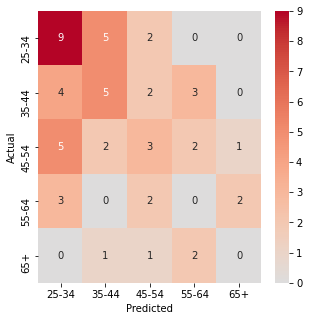

In [26]:
predictions = search.predict(age_X_test)

print("Accuracy: ", accuracy_score(age_y_test, predictions))
print(classification_report(age_y_test, predictions))
print(confusion_matrix(age_y_test, predictions))

confusion_matrix_heatmap(confusion_matrix(age_y_test,predictions), search.classes_)

## 3. Authorship Analysis

Predicting the user who produced the Tweet.

In [27]:
def confusion_matrix_percent_heatmap(cm, index):
    cmdf = pd.DataFrame(cm, index = index, columns=index)
    percents = cmdf.div(cmdf.sum(axis=1), axis=0)*100
    dims = (10, 10)
    fig, ax = plt.subplots(figsize=dims)
    sns.heatmap(percents, annot=True, cmap="coolwarm", center=0, vmin=0, vmax=100)
    ax.set_ylabel('Actual')    
    ax.set_xlabel('Predicted')
    cbar = ax.collections[0].colorbar
    cbar.set_ticks([0, 25, 50, 75, 100])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])

### Document Object and Processor

In [28]:
hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")
url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")

def preprocess(text):
    p_text = hashtag_re.sub("[hashtag]",text)
    p_text = mention_re.sub("[mention]",p_text)
    p_text = url_re.sub("[url]",p_text)
    p_text = ftfy.fix_text(p_text)
    return p_text

tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") #([]|words|other non-space)
def tokenise(text):
    return tokenise_re.findall(text)

class Document:
    def __init__(self, meta={}):
        self.meta = meta
        self.tokens_fql = Counter() #empty Counter, ready to be added to with Counter.update.
        self.ht_fql = Counter()
        self.num_tokens = 0
        self.text = ""
        
    def extract_features_from_text(self, text):
        hts = hashtag_re.findall(text)
        self.ht_fql.update([ht.lower() for ht in hts])
        p_text = preprocess(text)
        tokens = tokenise(p_text)
        lower_tokens = [t.lower() for t in tokens]
        self.num_tokens += len(lower_tokens)
        self.tokens_fql.update(lower_tokens) #updating Counter counts items in list, adding to existing Counter items.
        self.text += text
        
    def extract_features_from_texts(self, texts): #texts should be iterable text lines, e.g. read in from file.
        for text in texts:
            extract_features_from_text(text)
            
    def average_token_length(self):
        sum_lengths = 0
        for key, value in self.tokens_fql.items():
            sum_lengths += len(key) * value
        return sum_lengths / self.num_tokens

In [29]:
class DocumentProcessor(BaseEstimator, TransformerMixin):
    def __init__(self, process_method):
        self.process_method = process_method
    
    def fit(self, X, y=None): #no fitting necessary, although could use this to build a vocabulary for all documents, and then limit to set (e.g. top 1000).
        return self

    def transform(self, documents):
        for document in documents:
            yield self.process_method(document)

In [30]:
def get_tokens_fql(document):
    return document.tokens_fql

def get_ht_fql(document):
    return document.ht_fql

def get_text_stats(document):
    ttr = len(document.tokens_fql) / document.num_tokens
    return {'avg_token_length': document.average_token_length(), 'ttr': ttr }

def read_list(file):
    with open(file) as f:
        items = []
        lines = f.readlines()
        for line in lines:
            items.append(line.strip())
    return items

fws = read_list("functionwords.txt")

def get_fws_fql(document):
    fws_fql = Counter({t: document.tokens_fql[t] for t in fws}) #dict comprehension, t: fql[t] is token: freq.
    return +fws_fql

### Load Data

In [31]:
def import_tweets_json(folder):
    jsonfiles = [join(folder, f) for f in listdir(folder) if isfile(join(folder, f)) and f.endswith(".json")]
    for jf in jsonfiles:
        with open(jf) as f:
            data = json.load(f)
            tweets = data.pop('tweets')
            metadata = data
        print("Processing " + metadata['screen_name'])
        for tweet in tweets:
            doc = Document(meta=metadata)
            doc.extract_features_from_text(tweet['text'])
            yield doc

In [32]:
corpus = []
corpus.extend(import_tweets_json("mps-json-10"))

Processing @BorisJohnson
Processing @tom_watson
Processing @JoJohnsonUK
Processing @ChukaUmunna
Processing @YvetteCooperMP
Processing @theresa_may
Processing @CarolineLucas
Processing @Anna_Soubry
Processing @jeremycorbyn
Processing @Jeremy_Hunt


### Train/Test Split

In [33]:
y = [d.meta['screen_name'] for d in corpus]
X = corpus

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0, stratify=y)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

13828 3458
13828 3458


### Pipeline

In [35]:
model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('hts', Pipeline([
                ('processor', DocumentProcessor(process_method = get_ht_fql)),
                ('vectorizer', DictVectorizer()),
                ('binarize', Binarizer()),
            ])),
            ('word', Pipeline([
                ('processor', DocumentProcessor(process_method = None)), # to be set by grid search.
                ('vectorizer', DictVectorizer()),
                ('binarize', Binarizer()),
            ])),
            ('stats', Pipeline([
                ('processor', DocumentProcessor(process_method = get_text_stats)),
                ('vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    ('selector', SelectKBest(score_func = chi2)),
    ('standardize', StandardScaler(with_mean=False)),
    ('clf', None), # to be set by grid search.
])

param_grid={
    'union__word__processor__process_method': [get_fws_fql, get_tokens_fql],
    'selector__k': [50, 100, 150, 500],
    'clf': [MultinomialNB(), LogisticRegression(solver='liblinear', random_state=0, multi_class='ovr')],
}

### Grid Search

In [36]:
search = GridSearchCV(model, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0), 
                      return_train_score = False, 
                      scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid = param_grid,
                      verbose=2,
                      n_jobs=-1
                     )

search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   49.8s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('union',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('hts',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('processor',
                                                                                         DocumentProcessor(process_method=<function get_ht_fql at 0x1339424c0>)),
                                                                                        ('vectorizer',
                                                                                         DictVectorizer(dtype=<class 'numpy.float64...
                                                    solver='

In [37]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_selector__k,param_union__word__processor__process_method,params,split0_test_accuracy,split1_test_accuracy,...,std_test_recall_weighted,rank_test_recall_weighted,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,3.060470,0.060038,0.861581,0.053979,"MultinomialNB(alpha=1.0, class_prior=None, fit...",50,<function get_fws_fql at 0x13259ef70>,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.256688,0.280550,...,0.010970,16,0.241112,0.265840,0.270416,0.274718,0.254584,0.261334,0.012136,16
1,0.898541,0.088313,0.252718,0.037064,"MultinomialNB(alpha=1.0, class_prior=None, fit...",50,<function get_tokens_fql at 0x133942430>,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.407086,0.426970,...,0.008447,9,0.404495,0.420730,0.413971,0.398149,0.411089,0.409687,0.007776,9
2,2.970585,0.130716,0.814689,0.075129,"MultinomialNB(alpha=1.0, class_prior=None, fit...",100,<function get_fws_fql at 0x13259ef70>,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.313449,0.317787,...,0.006272,15,0.300117,0.315153,0.319383,0.323174,0.307851,0.313136,0.008262,14
3,0.904698,0.071636,0.246873,0.043239,"MultinomialNB(alpha=1.0, class_prior=None, fit...",100,<function get_tokens_fql at 0x133942430>,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.452278,0.481923,...,0.010226,6,0.454106,0.480833,0.466731,0.459610,0.462514,0.464759,0.009025,6
4,2.810510,0.102553,0.752489,0.128518,"MultinomialNB(alpha=1.0, class_prior=None, fit...",150,<function get_fws_fql at 0x13259ef70>,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.331887,0.334056,...,0.003740,13,0.322143,0.332155,0.335578,0.338366,0.324834,0.330615,0.006201,13
5,0.802702,0.056766,0.206900,0.017599,"MultinomialNB(alpha=1.0, class_prior=None, fit...",150,<function get_tokens_fql at 0x133942430>,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.476500,0.514100,...,0.012507,5,0.479779,0.516557,0.491869,0.488239,0.493069,0.493902,0.012244,5
6,2.584265,0.185489,0.722415,0.080289,"MultinomialNB(alpha=1.0, class_prior=None, fit...",500,<function get_fws_fql at 0x13259ef70>,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.372740,0.384309,...,0.008368,11,0.373577,0.384364,0.375131,0.396819,0.380445,0.382067,0.008315,11
7,0.796289,0.085815,0.215601,0.017867,"MultinomialNB(alpha=1.0, class_prior=None, fit...",500,<function get_tokens_fql at 0x133942430>,"{'clf': MultinomialNB(alpha=1.0, class_prior=N...",0.569053,0.581345,...,0.004996,2,0.571538,0.584205,0.574159,0.583303,0.583747,0.579391,0.005413,2
8,3.148782,0.205880,0.732729,0.029476,"LogisticRegression(C=1.0, class_weight=None, d...",50,<function get_fws_fql at 0x13259ef70>,"{'clf': LogisticRegression(C=1.0, class_weight...",0.324657,0.332610,...,0.010303,14,0.299897,0.310393,0.303391,0.334732,0.307482,0.311179,0.012304,15
9,1.333308,0.088873,0.217765,0.026370,"LogisticRegression(C=1.0, class_weight=None, d...",50,<function get_tokens_fql at 0x133942430>,"{'clf': LogisticRegression(C=1.0, class_weight...",0.450832,0.468185,...,0.006453,7,0.440331,0.458526,0.451849,0.449539,0.442532,0.448555,0.006560,7


In [38]:
search.best_params_

{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='ovr', n_jobs=None, penalty='l2', random_state=0,
                    solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 'selector__k': 500,
 'union__word__processor__process_method': <function __main__.get_tokens_fql(document)>}

### Predictions

Accuracy:  0.6477732793522267
                 precision    recall  f1-score   support

   @Anna_Soubry       0.69      0.67      0.68       331
  @BorisJohnson       0.67      0.56      0.61       286
 @CarolineLucas       0.71      0.66      0.69       456
   @ChukaUmunna       0.61      0.58      0.60       279
   @Jeremy_Hunt       0.66      0.70      0.68       516
   @JoJohnsonUK       0.75      0.65      0.69       156
@YvetteCooperMP       0.67      0.58      0.62       322
  @jeremycorbyn       0.65      0.69      0.67       442
   @theresa_may       0.56      0.44      0.49       170
    @tom_watson       0.56      0.73      0.64       500

       accuracy                           0.65      3458
      macro avg       0.65      0.63      0.64      3458
   weighted avg       0.65      0.65      0.65      3458

[[223   1  10  13   8   2  15   6   2  51]
 [  8 159   8   8  46   5   9  12  11  20]
 [  9   6 303  30  26   6  17  28   7  24]
 [  7   3  30 162  14   1  14  16   6  2

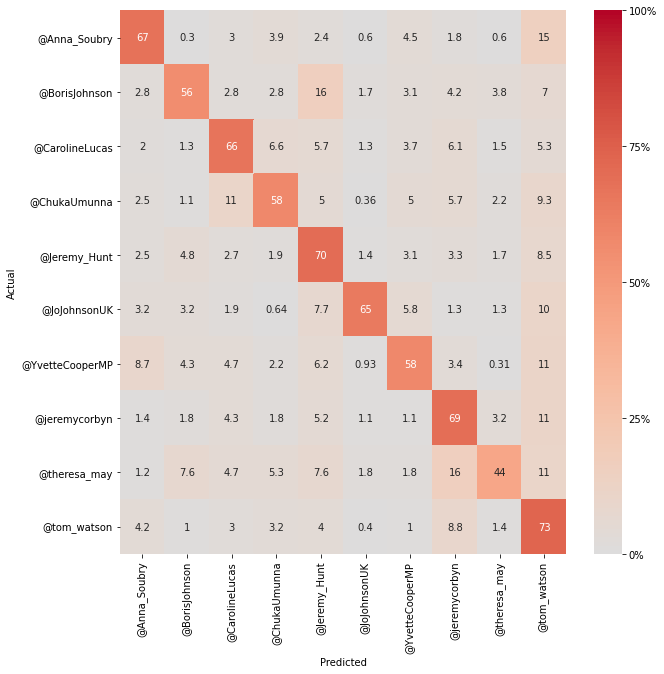

In [39]:
predictions = search.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

confusion_matrix_percent_heatmap(confusion_matrix(y_test,predictions), search.classes_)

### Error Analysis

In [41]:
X_test_texts = [x.text for x in X_test]

In [42]:
df = pd.DataFrame(list(zip(X_test_texts,y_test,predictions)), columns=["Tweet", "Actual", "Predicted"])

In [43]:
pd.options.display.max_colwidth = 300
df.head(10)

,Tweet,Actual,Predicted
0,She was even better after it - #dontmesswithSuRie #eurovision https://t.co/ROQnDECQEl,@YvetteCooperMP,@YvetteCooperMP
1,The OBR makes clear that the Tory corporation tax cuts will cost the Treasury billions. \n\nOur public services desperately need that money. #SpringStatement https://t.co/XOcZUCWv1v,@CarolineLucas,@jeremycorbyn
2,@philipjcowley Says a future VC 😉,@tom_watson,@tom_watson
3,"Delighted to be an @theRCN Nursing Champion for #Brighton Pavilion. Today’s @CommonsHealth report shows we have a lot to do to make our current &amp; future nursing staff feel valued, supported &amp; motivated in a health care system that celebrates their contribution to patient care.",@CarolineLucas,@CarolineLucas
4,"In Thurrock, I met first time voters who voted Labour. I'm proud that our vision of hope inspired so many to vote for the very first time. https://t.co/nQp7Hfj5fa",@jeremycorbyn,@jeremycorbyn
5,"@piersmorgan Too right. Just enjoy the moment and remember no one can go back in time to change what has happened, so work on your present to make yourself a wonderful future. Happy New Year in advance.",@tom_watson,@Jeremy_Hunt
6,"Hang on. Police officers were cut by 2,715 in 12 months from Sept 2015 - Sept 2016 #canttrustawordshesays https://t.co/UYBNMwaSf2",@YvetteCooperMP,@YvetteCooperMP
7,@joerayment91 @GloriaDePiero @TracyBrabin https://t.co/vz0tkGxmNc,@tom_watson,@tom_watson
8,@tobyh45 @mccanntb @LBC Ring in Toby.,@tom_watson,@tom_watson
9,Brexiteers promised a ban on live animal exports. \n\nNow @MichaelGove says it won't happen. \n\nThis Tory Brexit is built on lies. \n\nWe urgently need a #PeoplesVote https://t.co/P5bV2E59hR,@CarolineLucas,@CarolineLucas


In [44]:
# See when Theresa May's tweets are predicted incorrectly
df[df['Actual'].str.match("@theresa_may") & ~df['Predicted'].str.match("@theresa_may")]

,Tweet,Actual,Predicted
31,"Labour’s policies would be devastating to businesses and working families across our country.\n \nBy contrast, under this Government wages are growing, unemployment is falling and we are delivering a Brexit deal that is good for our economy.\n\n#PMQs https://t.co/YkvbGgHC6B",@theresa_may,@jeremycorbyn
39,"Labour has turned its back on investment, growth, jobs. A Labour Party that will always put politics before people. https://t.co/Hnua5uIAo5",@theresa_may,@tom_watson
76,"Glad the @RedDevilsOnline were able to help, @Schofe. Happy birthday @ThisMorning! #ThisMorning30 https://t.co/sb7keZwEsX",@theresa_may,@tom_watson
107,UK is offering help to those hit by the devastating Hurricane Irma https://t.co/wVbTOei3x0,@theresa_may,@BorisJohnson
120,Delighted to see some of Britain's unsung heroes honoured at tonight's @PrideOfBritain awards. https://t.co/2Yq022fkeP,@theresa_may,@tom_watson
...,...,...,...
3316,My Government is developing proposals to crack down on puppies being reared in unhealthy circumstances by unscrupulous breeders who have a total disregard for their welfare. It’s absolutely right we do everything we can to eradicate animal cruelty from our society. https://t.co/jXe4FiyNdw,@theresa_may,@jeremycorbyn
3364,"Please do follow and support @Equinepuk - a Leeds based equine therapy organisation championed by @andreajenkyns. It offers free sessions to children struggling with bullying, autism and learning difficulties; and adults battling depression and overcoming other illnesses. https://t.co/ZkB9pDBWI7",@theresa_may,@tom_watson
3416,Vote for better local services and lower council tax. Vote @Conservatives today. https://t.co/S5HAXIx4Ut,@theresa_may,@tom_watson
3440,Thank you @Malala. International experts agree that young people need 12 years of quality education if they’re to fulfil their potential. I want #CHOGM18 to be the summit where the Commonwealth agrees to make that the goal for all our members. https://t.co/TBNfU9GEJk,@theresa_may,@BorisJohnson


In [45]:
# See when Theresa May's tweets are predicted as Jeremy Corbyn
df[df['Actual'].str.match("@theresa_may") & df['Predicted'].str.match("@jeremycorbyn")]

,Tweet,Actual,Predicted
31,"Labour’s policies would be devastating to businesses and working families across our country.\n \nBy contrast, under this Government wages are growing, unemployment is falling and we are delivering a Brexit deal that is good for our economy.\n\n#PMQs https://t.co/YkvbGgHC6B",@theresa_may,@jeremycorbyn
453,"In my speech tomorrow, I will show how and why my Government must fulfil our duty to Britain https://t.co/vOp8HRgoag",@theresa_may,@jeremycorbyn
472,Congratulations to @PaulDaviesPembs who has today been elected Leader of @WelshConserv in the Welsh Assembly. There has never been a more vital time for us to hold the failing Labour-run Welsh Government to account. I know he’ll do a fantastic job speaking up for the Welsh people,@theresa_may,@jeremycorbyn
477,I would like to thank everyone working in our emergency services on #999DayUK. They go above and beyond every day to help save lives and keep us safe.,@theresa_may,@jeremycorbyn
584,"It was great to meet so many inspirational people last night @10DowningStreet, supporting the government’s important partnership with #SoccerAid for @Unicef. Together we’re helping children in danger around the world. https://t.co/L1ngbdM07R",@theresa_may,@jeremycorbyn
754,"On the 350th anniversary of Guru Gobind Singh's birth, I'd like to wish all Sikhs celebrating a very blessed and happy Gurpurab.",@theresa_may,@jeremycorbyn
790,"We will create jobs, fund public services &amp; build a country that works for everyone. Labour will borrow £500 billion, hurting working people https://t.co/DqD4zzt0IT",@theresa_may,@jeremycorbyn
1020,I am deeply saddened by the tragic loss of life at Grenfell Tower. My thoughts are with all those affected and the emergency services.,@theresa_may,@jeremycorbyn
1159,"I had a wonderful time spending today with military personnel, veterans, and their families at Armed Forces Day celebrations in Llandudno. #ArmedForcesDay2018 https://t.co/9p8if8KwLh",@theresa_may,@jeremycorbyn
1388,I was delighted to host an Eid reception at @10DowningStreet to celebrate the inspiring contribution made by British Muslims in this country #EidMubarak https://t.co/EktPQE5W40,@theresa_may,@jeremycorbyn


## 4. Sentiment Analysis

Build a custom classifier to predict the sentiment of Tweets.

In [47]:
# Import words from sentiment lexicon on disk
def import_sentiment_words(file):
    with open(file) as f:
        words = f.read().splitlines()
    return words

### Load Sentiment Words

In [48]:
# Obtain positive and negative sentiment words
negative_sentiment_words = import_sentiment_words("sentiment/opinion-lexicon-English/negative-words-utf8.txt")
positive_sentiment_words = import_sentiment_words("sentiment/opinion-lexicon-English/positive-words-utf8.txt")
all_sentiment_words = negative_sentiment_words + positive_sentiment_words

### Helper Functions and Document Class

In [49]:
hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")
url_re = re.compile(r"(?:https?://)?(?:[-\w]+\.)+[a-zA-Z]{2,9}[-\w/#~:;.?+=&%@~]*")

def preprocess(text):
    p_text = hashtag_re.sub("[hashtag]",text)
    p_text = mention_re.sub("[mention]",p_text)
    p_text = url_re.sub("[url]",p_text)
    p_text = ftfy.fix_text(p_text)
    return p_text.lower()

tokenise_re = re.compile(r"(\[[^\]]+\]|[-'\w]+|[^\s\w\[']+)") #([]|words|other non-space)
def tokenise(text):
    return tokenise_re.findall(text)

class Document:
    def __init__(self, meta={}):
        self.meta = meta
        self.tokens_fql = Counter() #empty Counter, ready to be added to with Counter.update.
        self.pos_fql = Counter()
        self.ht_fql = Counter()
        self.adj_fql = Counter() # stores frequencies of adjectives in tweets
        self.sentiment_words_fql = Counter() # stores frequencies of words which appear in predefined list of words from sentiment lexicon
        self.pos_list = [] #empty list for pos tags from running text.
        self.num_tokens = 0
        self.text = ""
        
    def extract_features_from_text(self, text):
        self.text += text
        
        # Hashtag features
        hts = hashtag_re.findall(text)
        self.ht_fql.update([ht.lower() for ht in hts])
        
        # Preprocessing and tokenisation
        p_text = preprocess(text)
        tokens = tokenise(p_text)
        lower_tokens = [t.lower() for t in tokens]
        self.num_tokens += len(lower_tokens)
        self.tokens_fql.update(lower_tokens) #updating Counter counts items in list, adding to existing Counter items.
        
        # POS tags features
        pos_tagged = nltk.pos_tag(tokens)
        pos = [tag[1] for tag in pos_tagged]
        self.pos_fql.update(pos)
        self.pos_list.extend(pos)
        
        # FEATURE SET 1: Update adjectives frequency list (adjectives feature set)
        adj_tags = ['JJ', 'JJR', 'JJS']
        adjectives = [word for word, pos_tag in pos_tagged if pos_tag in adj_tags]
        self.adj_fql.update(adjectives)
        
        # FEATURE SET 2: Update sentiment words lexicon
        sentiment_words = [word for word in lower_tokens if word in all_sentiment_words]
        self.sentiment_words_fql.update(sentiment_words)
        
    def extract_features_from_texts(self, texts): #texts should be iterable text lines, e.g. read in from file.
        for text in texts:
            extract_features_from_text(text)
            
    def average_token_length(self):
        sum_lengths = 0
        for key, value in self.tokens_fql.items():
            sum_lengths += len(key) * value
        return sum_lengths / self.num_tokens

In [63]:
def get_tokens_fql(document):
    return document.tokens_fql

def get_ht_fql(document):
    return document.ht_fql

def get_adj_fql(document):
    return document.adj_fql

def get_sentiment_words_fql(document):
    return document.sentiment_words_fql

def get_text_stats(document):
    ttr = len(document.tokens_fql) / document.num_tokens
    return {'avg_token_length': document.average_token_length(), 'ttr': ttr }

def get_pos_fql(document):
    return document.pos_fql

def read_list(file):
    with open(file) as f:
        items = []
        lines = f.readlines()
        for line in lines:
            items.append(line.strip())
    return items

fws = read_list("functionwords.txt")

def get_fws_fql(document):
    fws_fql = Counter({t: document.tokens_fql[t] for t in fws}) #dict comprehension, t: fql[t] is token: freq.
    return +fws_fql

### Load Data

In [64]:
def import_tweets_docs(file, label):
    metadata = {'label': label}
    with open(file) as f:
        tweets = f.readlines()
        for tweet in tweets:
            doc = Document(meta=metadata)
            doc.extract_features_from_text(tweet)
            yield doc

In [65]:
# Create corpus
corpus = []
corpus.extend(import_tweets_docs("sentiment/all/negative.txt", "negative"))
corpus.extend(import_tweets_docs("sentiment/all/positive.txt", "positive"))
corpus.extend(import_tweets_docs("sentiment/all/neutral.txt", "neutral"))

### Train/Test Split

In [66]:
y = [d.meta['label'] for d in corpus]
X = corpus

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 0, stratify=y)
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

17804 4452
17804 4452


### Pipeline

In [68]:
model = Pipeline([
    ('union', FeatureUnion(
        transformer_list = [
            ('hts', Pipeline([
                ('processor', DocumentProcessor(process_method = get_ht_fql)),
                ('vectorizer', DictVectorizer()),
                ('binarize', Binarizer()),
            ])),
            ('word', Pipeline([
                ('processor', DocumentProcessor(process_method = None)), # to be set by grid search.
                ('vectorizer', DictVectorizer()),
                ('binarize', Binarizer()),
            ])),
            ('stats', Pipeline([
                ('processor', DocumentProcessor(process_method = get_text_stats)),
                ('vectorizer', DictVectorizer()),
            ])),
        ],
    )),
    ('selector', SelectKBest(score_func = chi2)),
    ('standardize', StandardScaler(with_mean=False)),
    ('clf', None), # to be set by grid search.
])

param_grid={
#     'union__word__processor__process_method': [get_fws_fql, get_tokens_fql],
    'union__word__processor__process_method': [get_sentiment_words_fql], # get_adj_fql, get_sentiment_words_fql
    'selector__k': [50, 100, 150, 500],
    'clf': [MultinomialNB(), LogisticRegression(solver='liblinear', random_state=0, multi_class='ovr')],
}

### Grid Search

In [69]:
search = GridSearchCV(model, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0), 
                      return_train_score = False, 
                      scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted'],
                      refit = 'f1_weighted',
                      param_grid = param_grid,
                      verbose=2,
                      n_jobs=-1
                     )

search.fit(X_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   32.0s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=0, shuffle=True),
             error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('union',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('hts',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('processor',
                                                                                         DocumentProcessor(process_method=<function get_ht_fql at 0x12bc29820>)),
                                                                                        ('vectorizer',
                                                                                         DictVectorizer(dtype=<class 'numpy.float64...
                                                    n_jobs=N

In [70]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_selector__k,param_union__word__processor__process_method,params,split0_test_accuracy,split1_test_accuracy,...,std_test_recall_weighted,rank_test_recall_weighted,split0_test_f1_weighted,split1_test_f1_weighted,split2_test_f1_weighted,split3_test_f1_weighted,split4_test_f1_weighted,mean_test_f1_weighted,std_test_f1_weighted,rank_test_f1_weighted
0,0.215040,0.013491,0.080406,0.005233,"MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)",50,<function get_sentiment_words_fql at 0x12bdba700>,"{'clf': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 'selector__k': 50, 'union__word__processor__process_method': <function get_sentiment_words_fql at 0x12bdba700>}",0.556024,0.558551,...,0.003019,8,0.504776,0.507525,0.510438,0.508488,0.499444,0.506134,0.003810,8
1,0.226225,0.022553,0.079020,0.007370,"MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)",100,<function get_sentiment_words_fql at 0x12bdba700>,"{'clf': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 'selector__k': 100, 'union__word__processor__process_method': <function get_sentiment_words_fql at 0x12bdba700>}",0.564167,0.571188,...,0.004718,6,0.524905,0.530797,0.542927,0.536980,0.525900,0.532302,0.006823,6
2,0.215871,0.007780,0.070342,0.003753,"MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)",150,<function get_sentiment_words_fql at 0x12bdba700>,"{'clf': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 'selector__k': 150, 'union__word__processor__process_method': <function get_sentiment_words_fql at 0x12bdba700>}",0.571750,0.581859,...,0.005564,3,0.540617,0.550507,0.554167,0.544416,0.534032,0.544748,0.007126,4
3,0.218351,0.015747,0.074685,0.007905,"MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)",500,<function get_sentiment_words_fql at 0x12bdba700>,"{'clf': MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True), 'selector__k': 500, 'union__word__processor__process_method': <function get_sentiment_words_fql at 0x12bdba700>}",0.566414,0.588880,...,0.008265,4,0.539537,0.564621,0.546118,0.553974,0.541939,0.549238,0.009123,3
4,0.250957,0.009142,0.071786,0.002461,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='ovr', n_jobs=None, penalty='l2', random_state=0,\n solver='liblinear', tol=0.0001, verbose=0, warm...",50,<function get_sentiment_words_fql at 0x12bdba700>,"{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2', random_state=0, solver='liblinear', tol=0.0001, verbose=0,...",0.557709,0.560798,...,0.003770,7,0.510008,0.513037,0.518594,0.515888,0.504554,0.512416,0.004862,7
5,0.285210,0.014459,0.069630,0.003233,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='ovr', n_jobs=None, penalty='l2', random_state=0,\n solver='liblinear', tol=0.0001, verbose=0, warm...",100,<function get_sentiment_words_fql at 0x12bdba700>,"{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2', random_state=0, solver='liblinear', tol=0.0001, verbose=0,...",0.568941,0.577647,...,0.006384,5,0.535564,0.544725,0.549912,0.543780,0.531242,0.541044,0.006720,5
6,0.276307,0.008878,0.080992,0.016466,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='ovr', n_jobs=None, penalty='l2', random_state=0,\n solver='liblinear', tol=0.0001, verbose=0, warm...",150,<function get_sentiment_words_fql at 0x12bdba700>,"{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, mult

In [71]:
search.best_params_

{'clf': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='ovr', n_jobs=None, penalty='l2', random_state=0,
                    solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
 'selector__k': 500,
 'union__word__processor__process_method': <function __main__.get_sentiment_words_fql(document)>}

### Predictions

Accuracy:  0.5790655884995508
              precision    recall  f1-score   support

    negative       0.54      0.27      0.36       667
     neutral       0.54      0.82      0.65      2003
    positive       0.71      0.42      0.53      1782

    accuracy                           0.58      4452
   macro avg       0.60      0.50      0.51      4452
weighted avg       0.61      0.58      0.56      4452

[[ 179  426   62]
 [ 107 1644  252]
 [  44  983  755]]


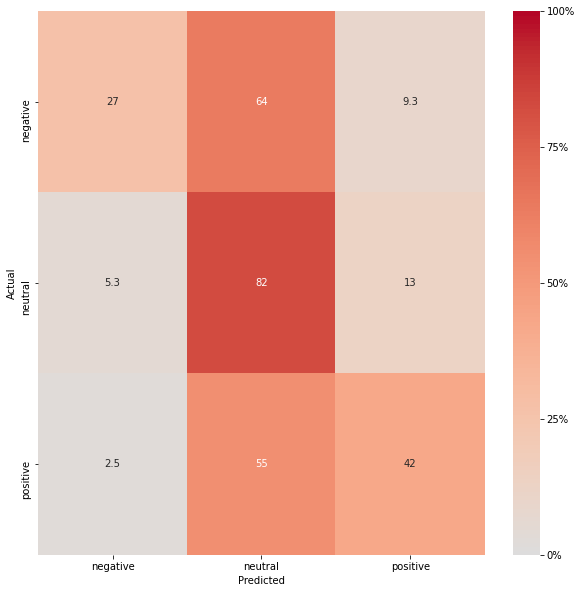

In [72]:
predictions = search.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

confusion_matrix_percent_heatmap(confusion_matrix(y_test,predictions), search.classes_)

### Error Analysis

In [73]:
X_test_texts = [x.text for x in X_test]

In [74]:
df = pd.DataFrame(list(zip(X_test_texts,y_test,predictions)), columns=["Tweet", "Actual", "Predicted"])

In [75]:
pd.options.display.max_colwidth = 300
df.head(16)

,Tweet,Actual,Predicted
0,"Milan fans living through Bee, he's living our dream. Just please get rid of galliani before buying the club https://t.co/w1VCvr2pr5\n",neutral,neutral
1,&gt;Gamergate is a hate group &gt;Amazon Prime Day is going to be bigger than Black Friday What do these two things have in common....\n,negative,negative
2,"IBM's Spectrum Protect named Gartner's ""Leaders"" Quadrant for Enterprise Backup Software: A Leader for the 10th time http://t.co/Pbxo95Gup6\n",neutral,neutral
3,"The moment I truly fell in love with Will was at the beginning of Sakizuke, when he plays Hannibal for the 1st time. #Hannibal #rewatch\n",positive,positive
4,"White Sox load the bases but don't score, so David Robertson in to pitch with a 6-4 lead in the bottom of the 9th.\n",neutral,neutral
5,Take me back to Friday night to the Eric church concert\n,positive,neutral
6,"""The Deadman makes no apologies about what he's done to Brock Lesnar ... or what he's about to do at #SummerSlam."" http://t.co/FFKWuiXhmu\n",neutral,neutral
7,A lot has happened while I was away sprain-spraying my ankle. Murray has taken the 1st set 6-3 in 50 mins &amp; is up a break at 2-1 in the 2nd.\n,positive,neutral
8,From the makers of the Sharknado franchise comes a new movie on Saturday called Lavalantula. I must see this.\n,positive,neutral
9,#RT The 3rd book in The Viking's Apprentice series has been released. Amazon users get it here http://t.co/0pJjo6xXN7 #amreading\n,positive,neutral


In [76]:
# When positive tweets are predicted incorrectly
df[df['Actual'].str.match("positive") & ~df['Predicted'].str.match("positive")]

,Tweet,Actual,Predicted
5,Take me back to Friday night to the Eric church concert\n,positive,neutral
7,A lot has happened while I was away sprain-spraying my ankle. Murray has taken the 1st set 6-3 in 50 mins &amp; is up a break at 2-1 in the 2nd.\n,positive,neutral
8,From the makers of the Sharknado franchise comes a new movie on Saturday called Lavalantula. I must see this.\n,positive,neutral
9,#RT The 3rd book in The Viking's Apprentice series has been released. Amazon users get it here http://t.co/0pJjo6xXN7 #amreading\n,positive,neutral
11,"This December 12th card is going to be loaded - Im hoping we get Rousey - Tate, and maybe Fedor's return, along with Conor - Aldo #UFC\n",positive,neutral
...,...,...,...
4442,Sony's 20th Anniversary sale going on now http://t.co/o98eV4BdyL\n,positive,neutral
4445,"When your sister plays Iron Maiden on a Saturday morning, you know your work as a brother is done.\n",positive,neutral
4446,@Fightincowboy i hope you plan on doing a Dark Souls 3 walkthrough when it comes out in march bro! I literally watch every single DS video\n,positive,neutral
4448,and the 17th is Star Wars Day :D\n,positive,neutral


In [77]:
# When negative tweets are predicted incorrectly
df[df['Actual'].str.match("negative") & ~df['Predicted'].str.match("negative")]

,Tweet,Actual,Predicted
24,@realteddylong Raw and Smackdown. The authority is doing a lousy job. They're doing everything under the sun to keep Seth Rollins as champ\n,negative,positive
43,"Oh @TFIFridayLIVE your name may say ""Live"" but the god awful ""The Vamps"" we're far from live. Cut any bands who mime please !\n",negative,neutral
46,For I've always hated slavery since the day that I was born....and we're off to join the IRA and we're off tomorrow morn....\n,negative,neutral
52,John Kasich applied all the rote Republican dogma until he found out he couldn't govern that way. He may be the GOP voice in the wilderness.\n,negative,neutral
79,still so sad I'm not going to Ed Sheeran the 25th :////\n,negative,neutral
...,...,...,...
4403,"//Screw this, if Kane doesn't return tomorrow, he'll be back in the fall.\n",negative,neutral
4415,"anyone having problems with Windows 10? may be coincidental but since i downloaded, my WiFi keeps dropping out. Itunes had a malfunction\n",negative,neutral
4435,Amazon's refusal to integrate nicely with the Android ecosystem may have been its undoing in the Fire phone market. http://t.co/6mBZz0eazc\n,negative,neutral
4443,"Dandy Don, Howard and Frank are all now back together. Frank Gifford dies at 84 years of age. Condolences to his families. May he RIP\n",negative,neutral


In [78]:
# When neutral tweets are predicted incorrectly
df[df['Actual'].str.match("neutral") & ~df['Predicted'].str.match("neutral")]

,Tweet,Actual,Predicted
10,I am still yet to see Zayn's full fledged smile with his tongue between his teeth after March :( #ZquadWantsZaynToSmile\n,neutral,positive
16,Selfishly need a good Hutch outing. Anything less may mess with rotation &amp; the perfectly planned-out David Price start in LA next Friday.\n,neutral,positive
36,"I love Meisha Tate,not a Rousey fan really,but I can't see the sense in a 3rd fight,it's gonna take a man to beat Ronda any time soon #UFC\n",neutral,positive
57,"Juventus are ready to let Simone Zaza go in January, with Arsenal interested in the 24-year-old striker. Fichajes - in Spanish\n",neutral,positive
58,"@_alexisaguirre_ Not sure if you'd enjoy them, but Forever the Sickest Kids. Coasts. Possibly Owl City? Sam Smith. The Neighborhood. U may??\n",neutral,positive
...,...,...,...
4349,@SF_England so basically anyone from this September...that's just brilliant news :( big massive thanks to George Osborne and his friends!\n,neutral,positive
4367,BAL Sun: Tom Brady says he's focused on getting ready for football http://t.co/rlLDdi0J0W\n,neutral,positive
4408,"A good few Arsenal fans still pulling for Giroud. Guess it's 3rd/4th in the league, Round of 16 in CL and maybe an FA Cup again.\n",neutral,positive
4416,Happy Friday. Here's Joe Biden being creepy with anime characters. http://t.co/vjFcdjfsvB\n,neutral,positive


In [79]:
# When neutral tweets are predicted as positive
df[df['Actual'].str.match("neutral") & df['Predicted'].str.match("positive")]

,Tweet,Actual,Predicted
10,I am still yet to see Zayn's full fledged smile with his tongue between his teeth after March :( #ZquadWantsZaynToSmile\n,neutral,positive
16,Selfishly need a good Hutch outing. Anything less may mess with rotation &amp; the perfectly planned-out David Price start in LA next Friday.\n,neutral,positive
36,"I love Meisha Tate,not a Rousey fan really,but I can't see the sense in a 3rd fight,it's gonna take a man to beat Ronda any time soon #UFC\n",neutral,positive
57,"Juventus are ready to let Simone Zaza go in January, with Arsenal interested in the 24-year-old striker. Fichajes - in Spanish\n",neutral,positive
58,"@_alexisaguirre_ Not sure if you'd enjoy them, but Forever the Sickest Kids. Coasts. Possibly Owl City? Sam Smith. The Neighborhood. U may??\n",neutral,positive
...,...,...,...
4349,@SF_England so basically anyone from this September...that's just brilliant news :( big massive thanks to George Osborne and his friends!\n,neutral,positive
4367,BAL Sun: Tom Brady says he's focused on getting ready for football http://t.co/rlLDdi0J0W\n,neutral,positive
4408,"A good few Arsenal fans still pulling for Giroud. Guess it's 3rd/4th in the league, Round of 16 in CL and maybe an FA Cup again.\n",neutral,positive
4416,Happy Friday. Here's Joe Biden being creepy with anime characters. http://t.co/vjFcdjfsvB\n,neutral,positive


In [80]:
# When neutral tweets are predicted as negative
df[df['Actual'].str.match("neutral") & df['Predicted'].str.match("negative")]

,Tweet,Actual,Predicted
119,"Batman killed, used a gun + lived in New York, not Gotham for the 1st few years in comics #batman #kindle #Amazon http://t.co/b2E995okYl\n",neutral,negative
145,Tomorrow at school I'm just going to think of Zayn's selfies so my day will be less terrible\n,neutral,negative
151,"First day back at work proper and it has been manic and fuck it, I'm booking that to go see the Milan derby in Jan as a late bday trip!\n",neutral,negative
274,I love REM but Sweetness Follows may be the most depressing song ever. Kurt Cobain may have even killed himself whilst listening to it ffs.\n,neutral,negative
366,Trump reiterates Hillary Clinton is worst sec state ever but Kerry may take the title over Iran deal\n,neutral,negative
...,...,...,...
4162,@Atomic_Moog @nick_elt @djc8008 swapping Kane for Giroud week 4. Hazard is a waste of coin as well so he may go next &amp; bring in Yaya or Kun\n,neutral,negative
4222,@criscyborg I cant see Rousey fighting you Jan 2 because she's filming a movie after &amp; u would destroy her face. You deserve the big payday\n,neutral,negative
4228,Prince George is two today. I hope he doesn't angrily destroy his birthday cake like i did on my 2nd birthday #familylegend\n,neutral,negative
4297,"It may be true that Monsanto is terrible at PR, but believe it or not, it's not an evil company. http://t.co/T0si6OyF44 #FeedThe9\n",neutral,negative


In [81]:
# When positive tweets are predicted as neutral
df[df['Actual'].str.match("positive") & df['Predicted'].str.match("neutral")]

,Tweet,Actual,Predicted
5,Take me back to Friday night to the Eric church concert\n,positive,neutral
7,A lot has happened while I was away sprain-spraying my ankle. Murray has taken the 1st set 6-3 in 50 mins &amp; is up a break at 2-1 in the 2nd.\n,positive,neutral
8,From the makers of the Sharknado franchise comes a new movie on Saturday called Lavalantula. I must see this.\n,positive,neutral
9,#RT The 3rd book in The Viking's Apprentice series has been released. Amazon users get it here http://t.co/0pJjo6xXN7 #amreading\n,positive,neutral
11,"This December 12th card is going to be loaded - Im hoping we get Rousey - Tate, and maybe Fedor's return, along with Conor - Aldo #UFC\n",positive,neutral
...,...,...,...
4442,Sony's 20th Anniversary sale going on now http://t.co/o98eV4BdyL\n,positive,neutral
4445,"When your sister plays Iron Maiden on a Saturday morning, you know your work as a brother is done.\n",positive,neutral
4446,@Fightincowboy i hope you plan on doing a Dark Souls 3 walkthrough when it comes out in march bro! I literally watch every single DS video\n,positive,neutral
4448,and the 17th is Star Wars Day :D\n,positive,neutral


In [82]:
# When positive tweets are predicted as negative
df[df['Actual'].str.match("positive") & df['Predicted'].str.match("negative")]

,Tweet,Actual,Predicted
54,should i read for my quiz tomorrow or procrastinate and just watch netflix instead?\n,positive,negative
233,Tech: Android&gt;Star Wars: Uprising launches September 10 on iOS and Android - GB: Star Wars canon is about t..http://t.co/oiTvPxGfby #mobile\n,positive,negative
250,"Mar 25 to Aug 25 zquad faced many problems,got hate,zroughts. Still this fam always stood up for Zayn. Proud. Pass it on\n",positive,negative
277,@Ceilidhann @BeckiHawkes however conflicted I may feel about Watchman's publication this is a hella great upside to it.\n,positive,negative
333,"I'm going to sob like a child at Foo Fighters tomorrow, I can just feel it\n",positive,negative
401,Nearing the end of Season the 1st of HANNIBAL. I love it so much already I'm devastated in advance that the show stopped before Clarice.\n,positive,negative
546,"@EephusBlue - C'mon, stick around. It'll about to get ""Game of Thrones"" level bloody on here.\n",positive,negative
758,"Here's the AM message form PFBC this Sunday for those away for Labor Day...""Web of Lies"" in Acts 5:6-11 https://t.co/qjZjRxlNHV via @YouTube\n",positive,negative
821,@cthagod Nia Long didn't have a problem with it when Ice Cube said it in Friday. That's what really matters\n,positive,negative
1126,@sportsandra 1) High-life 2) CRAP 3) Grateful Dead for three nights over the 4th of July @ Soldier Field\n,positive,negative


In [83]:
# When negative tweets are predicted as positive
df[df['Actual'].str.match("negative") & df['Predicted'].str.match("positive")]

,Tweet,Actual,Predicted
24,@realteddylong Raw and Smackdown. The authority is doing a lousy job. They're doing everything under the sun to keep Seth Rollins as champ\n,negative,positive
139,If I wake up tomorrow and Seth Rollins is still the champ I will be so pissed off\n,negative,positive
236,@Lexus just told by @MotorWorldLexus no loaner car until the 27th great Lexus experience.Definitely not the expectation that was set at sale\n,negative,positive
316,Having a day off today yesterday went absolutely terribly and I was at foo fighters last night so will be back tomorrow. Enjoy your Sunday's\n,negative,positive
325,I sat through the whole of Sharknado 2 I'm pretty sure NS is nothing compared to that shit.\n,negative,positive
...,...,...,...
4224,"Why does Tom Cruise take 10,000 times to figure things out in the movie Edge Of Tomorrow, but gets it right 1st time in Mission Impossible?\n",negative,positive
4342,Don't want to hear Seth Rollins Speech about how great he is tomorrow bruh.\n,negative,positive
4369,I love Ozil but how on earth is he the 1st choice corner-kick taker for both Germany and Arsenal? What the hell does he do in training??\n,negative,positive
4376,I'm slightly bummed the Foo Fighters are playing Friday night of ACL rather than Sunday. I'm pretty much not gonna care the other 2 days.\n,negative,positive


In [84]:
# When negative tweets are predicted as neutral
df[df['Actual'].str.match("negative") & df['Predicted'].str.match("neutral")]

,Tweet,Actual,Predicted
43,"Oh @TFIFridayLIVE your name may say ""Live"" but the god awful ""The Vamps"" we're far from live. Cut any bands who mime please !\n",negative,neutral
46,For I've always hated slavery since the day that I was born....and we're off to join the IRA and we're off tomorrow morn....\n,negative,neutral
52,John Kasich applied all the rote Republican dogma until he found out he couldn't govern that way. He may be the GOP voice in the wilderness.\n,negative,neutral
79,still so sad I'm not going to Ed Sheeran the 25th :////\n,negative,neutral
89,"Just gonna say it: The lyrics in ""Bad Blood"" sound like they were written by a 7th grader. ""Done"" doesn't have two syllables, Taylor.\n",negative,neutral
...,...,...,...
4402,@picardonhealth @jdvorkin Yellow journalism. But you know? This may be Harper's Waterloo\n,negative,neutral
4403,"//Screw this, if Kane doesn't return tomorrow, he'll be back in the fall.\n",negative,neutral
4415,"anyone having problems with Windows 10? may be coincidental but since i downloaded, my WiFi keeps dropping out. Itunes had a malfunction\n",negative,neutral
4435,Amazon's refusal to integrate nicely with the Android ecosystem may have been its undoing in the Fire phone market. http://t.co/6mBZz0eazc\n,negative,neutral


### Summary

Firstly, I developed a basic sentiment classifier (using GridSearch to obtain optimal hyperparameters) with 3 classes (positive, negative and neutral) using a combination of both previous lab work and online research (sklearn documentation). 2 specific feature sets were explored and evaluated on the tweets corpus: just adjectives and words from a sentiment lexicon. It was found using just adjectives obtained an accuracy of ~55%. Using words from a sentiment lexicon (i.e. keeping only words in tweets which belong to the sentiment lexicon word list) achieved an improved accuracy of ~58% following GridSearch.